# Transfer Learning

In this notebook, you will fine-tune a pretrained ResNet to a small dataset of real images.

## Your Tasks

- Run this notebook and then test the trained network with your own image(s). Make a photo (e.g. with your smartphone), load it into colab or in the local directory where this notebook lies and run the cell on the very bottom of this notebook with your photo. Does it work?
- Compare accuracies using a pretrained and non-pretrained model? (set pretrained=False when loading resnet and train the whole model)
- Try to get better accuracy. My tips:
  - *Beginner Level*: Add data augmentation (be sure to re-run the data-loader cells for that) - see https://pytorch.org/vision/stable/transforms.html#transforms-on-pil-image-and-torch-tensor I'd especially recomment RandomHorizontalFlip & RandomAffine, ColorJitter might also be interesting. Remember to only apply it to the train loader ;-)
  - *Advanced Level*: Add more layers to your classification head, I suggest: `Linear->BatchNorm->Dropout(p=0.25)->Relu -> Linear->BatchNorm->Dropout(p=0.5)->Relu`. The number of hidden units in this head should be something like 256 in each Linear layer
  - *Expert Level*: "Unfreeze" additional layers of the ResNet, e.g. all modules in `resnet.layer4`, and fine-tune them with a small learning rate (e.g. 0.01). You will have to `requires_grad` to all layers in this part of the network, add the parameters to the optimizer and also put `resnet.layer4` into train/eval mode in the train loop. Sometimes it also works well to retrain the new classification head plus unfreeze all BatchNorm layers in the network. I added some comments in the train loop so that you can find the places where you should implement that.
- Bonus Tasks:
  - Train this dataset with the model that you used for MNIST, from scratch. How well does it work?
  - What classes is the model good at, where is the model bad? Output a confusion matrix on the validation set.
  - Try other base-architectures. resnet34, resnet101, resnet50, resnet152 should all be easy, but there are many more available in PyTorch: https://pytorch.org/docs/stable/torchvision/models.html Some might require building the classification head in a different way.
  - Build an application that grabs a video from your webcam and classifies it.
 

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms

from torch.utils.tensorboard import SummaryWriter

import numpy as np

import matplotlib.pyplot as plt

from pathlib import Path

from PIL import Image

# helpful library to print model summaries from https://github.com/TylerYep/torchinfo
!pip install torchinfo
from torchinfo import summary

## Loading the data

This is a dataset with sign language digits from https://github.com/ardamavi/Sign-Language-Digits-Dataset

![](https://raw.githubusercontent.com/ardamavi/Vocalize-Sign-Language/master/Assets/Ours%20Dataset%20Preview.jpg)


Here is a simple example how you could download the dataset in colab. If it does not work on your local copy, just download the zip from [here](https://) and unzip it to `data/sign-language` subfolder in the directory where your jupyter notebook lives.

In [2]:
!wget -O sign-language.zip https://www.dropbox.com/s/8pv426zcxxrbktu/sign-language.zip?dl=0

--2022-05-02 20:13:39--  https://www.dropbox.com/s/8pv426zcxxrbktu/sign-language.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/8pv426zcxxrbktu/sign-language.zip [following]
--2022-05-02 20:13:39--  https://www.dropbox.com/s/raw/8pv426zcxxrbktu/sign-language.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7ad038f49d87d080f1bbd563ba.dl.dropboxusercontent.com/cd/0/inline/BkgZBsMuEVI_DYEszkQre6jFSxp9UuKGxhzPWDmzKsEZ74CMVDmhfW7ktV7JzUVRPlSUxxmJxfUco6rnv9IH5Eu2puZDIX13LZeWE4LoHzfm2i2EX8oZ3_Atl3d2H-67lLbmoAQG4_6XzUSA3XeSUMb4m5EPyl-dmvimspcCXmTjGA/file# [following]
--2022-05-02 20:13:39--  https://uc7ad038f49d87d080f1bbd563ba.dl.dropboxusercontent.com/cd/0/inline/BkgZBsMuEVI_DYEszkQre6jFSxp9UuKGxhzPWDmzKsEZ74CM

In [3]:
!unzip -q -o sign-language.zip -d data
!ls data/sign-language

train  valid


The `trian` and `valid` folder each have subdirectories for each class:

In [4]:
!ls data/sign-language/train

0  1  2  3  4  5  6  7	8  9


In [5]:
!ls data/sign-language/train/0

IMG_1118.JPG  IMG_4159.JPG  IMG_4506.JPG  IMG_4886.JPG	IMG_5234.JPG
IMG_1128.JPG  IMG_4170.JPG  IMG_4533.JPG  IMG_4896.JPG	IMG_5244.JPG
IMG_1138.JPG  IMG_4181.JPG  IMG_4543.JPG  IMG_4906.JPG	IMG_5255.JPG
IMG_1148.JPG  IMG_4193.JPG  IMG_4554.JPG  IMG_4916.JPG	IMG_5266.JPG
IMG_1158.JPG  IMG_4203.JPG  IMG_4564.JPG  IMG_4926.JPG	IMG_5276.JPG
IMG_1169.JPG  IMG_4213.JPG  IMG_4574.JPG  IMG_4936.JPG	IMG_5286.JPG
IMG_1179.JPG  IMG_4223.JPG  IMG_4584.JPG  IMG_4946.JPG	IMG_5297.JPG
IMG_1189.JPG  IMG_4233.JPG  IMG_4594.JPG  IMG_4956.JPG	IMG_5308.JPG
IMG_1199.JPG  IMG_4243.JPG  IMG_4604.JPG  IMG_4966.JPG	IMG_5318.JPG
IMG_1209.JPG  IMG_4254.JPG  IMG_4614.JPG  IMG_4976.JPG	IMG_5328.JPG
IMG_1219.JPG  IMG_4266.JPG  IMG_4624.JPG  IMG_4986.JPG	IMG_5341.JPG
IMG_1229.JPG  IMG_4276.JPG  IMG_4634.JPG  IMG_4996.JPG	IMG_5350.JPG
IMG_1239.JPG  IMG_4286.JPG  IMG_4644.JPG  IMG_5007.JPG	IMG_5360.JPG
IMG_1249.JPG  IMG_4296.JPG  IMG_4674.JPG  IMG_5017.JPG	IMG_5370.JPG
IMG_1260.JPG  IMG_4306.JPG  IMG_4684.JPG  IMG_50


Lets setup dataloaders and datasets. Since the data is already in a quite common directory layout, we can use the [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) class from `torchvision` and don't even need to write our own data loader. But first, we need to specify the transformations that should be applied to the images before handing them to the neural network. Since the images might be of different size, we resize them. 

In [6]:
# imagenet pixel mean and std deviation
imagenet_stats = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

valid_transforms = transforms.Compose([
    transforms.Resize(100),
    transforms.CenterCrop(100),
    transforms.ToTensor(),
    transforms.Normalize(*imagenet_stats)
])

train_transforms = transforms.Compose([
    transforms.Resize(100),
    transforms.CenterCrop(100),
    # TODO: add more/other augmentations here
    transforms.ToTensor(),
    transforms.Normalize(*imagenet_stats)
])

data_dir = Path('data/sign-language')

train_data = datasets.ImageFolder(
    data_dir / 'train', 
    train_transforms
)
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=64, shuffle=True, num_workers=4)

valid_data = datasets.ImageFolder(
    data_dir / 'valid', 
    valid_transforms
)
valid_loader = torch.utils.data.DataLoader(
    valid_data, batch_size=128, shuffle=True, num_workers=4)

train_data

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Dataset ImageFolder
    Number of datapoints: 1662
    Root location: data/sign-language/train
    StandardTransform
Transform: Compose(
               Resize(size=100, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(100, 100))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

## Look at the data

Lets grab a batch of data and take a look at the data

In [7]:
X, y = next(iter(train_loader))
X.shape

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([64, 3, 100, 100])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


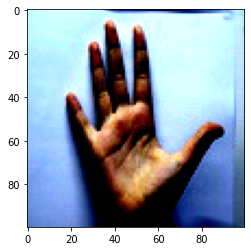

In [8]:
plt.imshow(X[0].permute(1, 2, 0).numpy())

The colors of the image seem strange since the last transform that we passed to our DataLoader was [Normalize](https://pytorch.org/docs/stable/torchvision/transforms.html?highlight=normalize#torchvision.transforms.Normalize). We can undo that normalization for visualizing the data. A call to permute is needed because Tensors from our DataLoader have CHW layout (channel dimension first, a convention in PyTorch), but matplotlib wants HWC layout (channel dimension last). If you are unsure what I'm talking about try printing the shape of X before and after the call to permute.

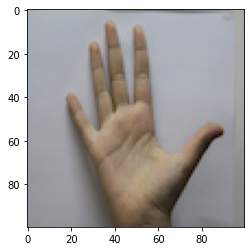

In [9]:
def denormalize(x):
    return (x * imagenet_stats[1]) + imagenet_stats[0]
    

plt.imshow(denormalize(X[0].permute(1, 2, 0).numpy()))

Lets take a look at some images and their labels.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


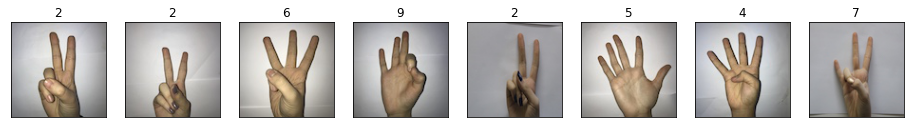

In [10]:
def to_rgb(x):
    return np.clip(denormalize(x.permute(1, 2, 0).numpy()), 0, 1)

plt.figure(figsize=(16, 4))
for X, y in train_loader:
    X = X[:8]
    for i, (img, lbl) in enumerate(zip(X, y)):
        plt.subplot(1, len(X), i+1)
        plt.title(str(lbl.item()))
        plt.imshow(to_rgb(img))
        plt.xticks([])
        plt.yticks([])
    break

## Preparing a Resnet for Finetuning

Lets load the pretrained ResNet18 model:

In [12]:
resnet = models.resnet18(pretrained=True)
summary(resnet, input_size=(64, 3, 100, 100))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   --                        --
├─Conv2d: 1-1                            [64, 64, 50, 50]          9,408
├─BatchNorm2d: 1-2                       [64, 64, 50, 50]          128
├─ReLU: 1-3                              [64, 64, 50, 50]          --
├─MaxPool2d: 1-4                         [64, 64, 25, 25]          --
├─Sequential: 1-5                        [64, 64, 25, 25]          --
│    └─BasicBlock: 2-1                   [64, 64, 25, 25]          --
│    │    └─Conv2d: 3-1                  [64, 64, 25, 25]          36,864
│    │    └─BatchNorm2d: 3-2             [64, 64, 25, 25]          128
│    │    └─ReLU: 3-3                    [64, 64, 25, 25]          --
│    │    └─Conv2d: 3-4                  [64, 64, 25, 25]          36,864
│    │    └─BatchNorm2d: 3-5             [64, 64, 25, 25]          128
│    │    └─ReLU: 3-6                    [64, 64, 25, 25]          --
│

The first step in pretraining is to "freeze" all the layers. We can do this by setting the requires_grad property to False. During training, gradients for these layers are not computed and the optimizer will not update the layer weights.

In [13]:
for param in resnet.parameters():
    param.requires_grad = False

We now want to replace the original 1000-way classifier layer with our own version. We will only train this new "head" of the network. Luckily for us, the ResNet in PyTorch has a property called "fc" (fully connected) that corresponds to the original classification head:

In [14]:
resnet.fc

Linear(in_features=512, out_features=1000, bias=True)

Lets replace this with our own custom head. 

To get even better results, you could replace this sub-network with additional layers: use nn.Linear, nn.BatchNorm1d, nn.Dropout and nn.ReLU!

In [17]:
# replace fully connected layer
resnet.fc = nn.Sequential(
    # TODO: add more layers here
    nn.Linear(512, 10, bias=True),
)
summary(resnet, input_size=(64, 3, 100, 100))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   --                        --
├─Conv2d: 1-1                            [64, 64, 50, 50]          (9,408)
├─BatchNorm2d: 1-2                       [64, 64, 50, 50]          (128)
├─ReLU: 1-3                              [64, 64, 50, 50]          --
├─MaxPool2d: 1-4                         [64, 64, 25, 25]          --
├─Sequential: 1-5                        [64, 64, 25, 25]          --
│    └─BasicBlock: 2-1                   [64, 64, 25, 25]          --
│    │    └─Conv2d: 3-1                  [64, 64, 25, 25]          (36,864)
│    │    └─BatchNorm2d: 3-2             [64, 64, 25, 25]          (128)
│    │    └─ReLU: 3-3                    [64, 64, 25, 25]          --
│    │    └─Conv2d: 3-4                  [64, 64, 25, 25]          (36,864)
│    │    └─BatchNorm2d: 3-5             [64, 64, 25, 25]          (128)
│    │    └─ReLU: 3-6                    [64, 64, 25, 25]  

## Training the model - custom train loop

Lets train the model. I built my own train-loop here, the train loop using poutyne may be found further down:

In [18]:
def accuracy(output, label):
    return (output.argmax(1) == label).float().mean()

board = SummaryWriter()

# put complete model on GPU
device = 'cuda:0'
resnet = resnet.to(device)

# setup optimizer
opt = optim.SGD(
    [
        # train our new head with a high learning rate:
        {'params': resnet.fc.parameters(), 'lr': 1e-1}
        # TODO: add additional parameters you want to train, probably with another learning rate
    ],
    momentum=0.9, nesterov=True,
    weight_decay=1.e-4
)

step = 0

# put complete resnet into eval mode
# in order to prevent batchnorm from collecting new running statistics
resnet.eval()

# TODO: unfreeze additional layers in the resnet by setting requires_grad=True

for epoch in range(10):
    # put only head into train mode
    resnet.fc.train()
    # TODO: put other parts of resnet into train mode

    # train on mini batches
    losses = []
    for X, y in train_loader:
        opt.zero_grad()
        output = resnet(X.to(device))
        # compute loss
        loss = F.cross_entropy(output, y.to(device))
        losses.append(loss.item())
        board.add_scalar('loss/train', loss.item(), step)
        loss.backward()
        opt.step()
        step += 1
            
    # measure accuracy on the validation set
    with torch.no_grad():
      resnet.eval() # never forget this if you use batchnorm or dropout
      acc = np.mean([
          accuracy(resnet(X.to(device)).detach().cpu(), y)
          for X, y in valid_loader
      ])

    board.add_scalar('acc/valid', acc, epoch)
    print("epoch % 5d: loss: % 8.5f accuracy: %4.2f" % (epoch, np.mean(losses), acc.item()))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch     0: loss:  65.09324 accuracy: 0.81
epoch     1: loss:  3.83704 accuracy: 0.82
epoch     2: loss:  2.22167 accuracy: 0.87
epoch     3: loss:  1.32295 accuracy: 0.79
epoch     4: loss:  1.30976 accuracy: 0.88
epoch     5: loss:  0.70916 accuracy: 0.88
epoch     6: loss:  0.68265 accuracy: 0.84
epoch     7: loss:  0.52451 accuracy: 0.88
epoch     8: loss:  0.38068 accuracy: 0.85
epoch     9: loss:  0.45849 accuracy: 0.86


## Predict on your image!

Lets see if the network learnt to recognize sign language, and if you learnt some sign language yourself ;-) First, load an image from disc:

--2022-05-02 20:16:15--  https://raw.githubusercontent.com/tneumann/htw_cnn_lecture/master/one.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33385 (33K) [image/jpeg]
Saving to: ‘one.jpg’

one.jpg             100%[===================>]  32.60K  --.-KB/s    in 0.003s  

2022-05-02 20:16:16 (11.1 MB/s) - ‘one.jpg’ saved [33385/33385]



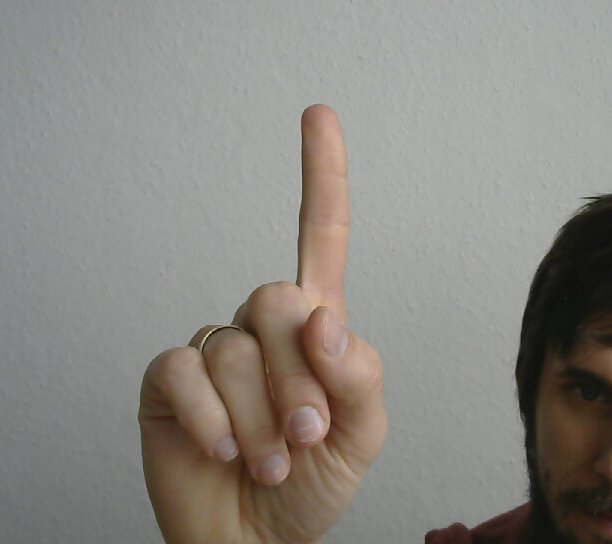

In [23]:
!wget https://raw.githubusercontent.com/tneumann/htw_cnn_lecture/master/one.jpg -O one.jpg
img = Image.open('one.jpg')
img

One important detail here is that we should now do the same transformations, that means especially normalizing according to the imagenet statistics. We can just call our transforms object to do this:

In [24]:
img_tensor = valid_transforms(img)
img_tensor.shape

torch.Size([3, 100, 100])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


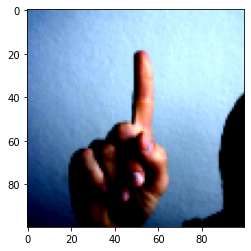

In [25]:
plt.imshow(img_tensor.permute(1, 2, 0))

Lets pass the image through our trained resnet:

In [26]:
resnet.eval()
resnet = resnet.cuda()
out = resnet(valid_transforms(img)[None].cuda())
out

tensor([[-15.4435,  99.1611,  20.2490,  -1.3920, -16.7955, -32.0842, -26.7648,
         -37.4945,  -8.3911,  20.8936]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [27]:
out.argmax()

tensor(1, device='cuda:0')

In [28]:
F.softmax(out, dim=1)

tensor([[0.0000e+00, 1.0000e+00, 5.3569e-35, 2.1019e-44, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0206e-34]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

Lets put this into a function that we can reuse:

--2022-05-02 20:16:26--  https://raw.githubusercontent.com/tneumann/htw_cnn_lecture/master/zero.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46364 (45K) [image/jpeg]
Saving to: ‘zero.jpg’

zero.jpg            100%[===================>]  45.28K  --.-KB/s    in 0.01s   

2022-05-02 20:16:26 (4.53 MB/s) - ‘zero.jpg’ saved [46364/46364]



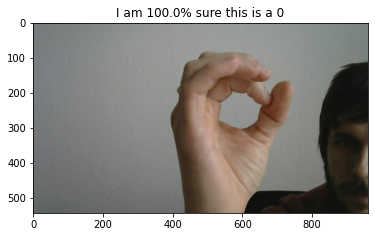

In [29]:
!wget https://raw.githubusercontent.com/tneumann/htw_cnn_lecture/master/zero.jpg -O zero.jpg

def predict_finger_digit(fn):
    img = Image.open(fn).convert('RGB')
    resnet.eval()
    out = resnet(valid_transforms(img)[None].cuda())
    cls = out.argmax().item()
    pct = 100 * F.softmax(out, dim=1)[0, cls]
    
    plt.title(f"I am {pct:.1f}% sure this is a {cls}")
    plt.imshow(img)
    
predict_finger_digit('zero.jpg')